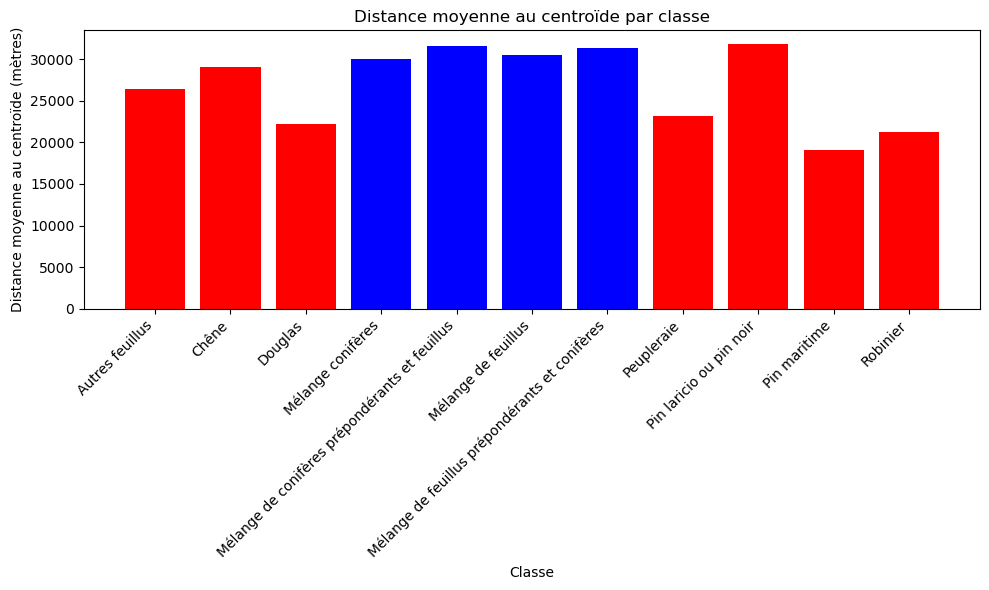

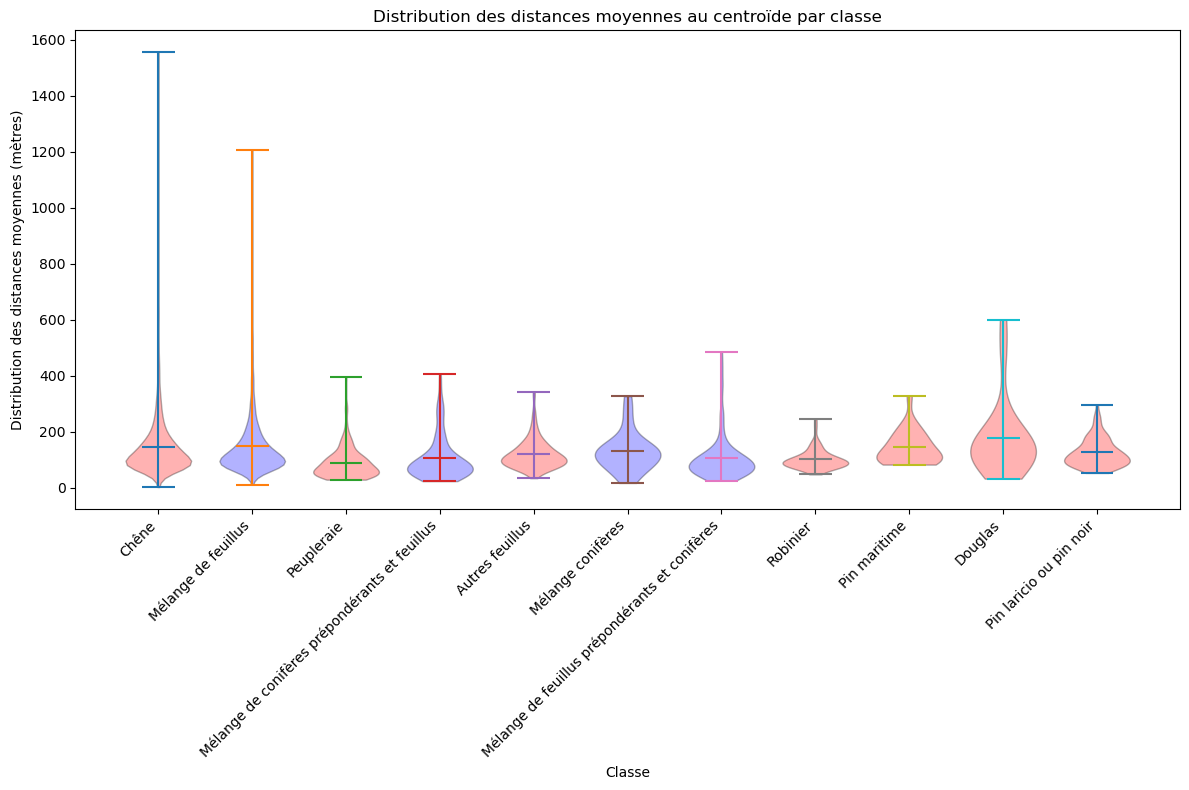

In [5]:
import os
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
import pandas as pd

# Charger les données shapefile
shapefile_path = "../results/data/sample/Sample_BD_foret_T31TCJ.shp"
output_dir = "../results/figure"
os.makedirs(output_dir, exist_ok=True)
output_quest1 = os.path.join(output_dir, "diag_baton_dist_centroide_classe.png")
output_quest2 = os.path.join(output_dir, "violin_plot_dist_centroide_by_poly_by_class.png")

data = gpd.read_file(shapefile_path)

# Charger le raster NDVI avec GDAL
ndvi_raster_path = "../results/data/img_pretraitees/Serie_temp_S2_ndvi.tif"
dataset = gdal.Open(ndvi_raster_path)

# Vérifier que le raster est valide et contient au moins une bande
if not dataset:
    raise FileNotFoundError(f"Impossible de charger le raster NDVI : {ndvi_raster_path}")
if dataset.RasterCount < 1:
    raise ValueError("Le raster NDVI ne contient aucune bande.")

# Lire la première bande du raster NDVI
band = dataset.GetRasterBand(1)
ndvi_array = band.ReadAsArray()
no_data_value = band.GetNoDataValue()

# Vérifier que le raster a bien été chargé
if ndvi_array is None:
    raise ValueError("Impossible de lire les données du raster NDVI.")

# Récupérer les dimensions et la géométrie du raster
nrows, ncols = ndvi_array.shape
transform = dataset.GetGeoTransform()

# Définir les classes bleues et rouges
classes_bleues = [
    "Mélange de feuillus",
    "Mélange conifères",
    "Mélange de conifères prépondérants et feuillus",
    "Mélange de feuillus prépondérants et conifères",
]

classes_rouges = [
    "Autres feuillus",
    "Chêne",
    "Robinier",
    "Peupleraie",
    "Douglas",
    "Pin laricio ou pin noir",
    "Pin maritime",
]

# Filtrer les données par classe
all_data = data[data["Nom_objet"].isin(classes_bleues + classes_rouges)]

# Fonction pour calculer la distance au centroïde
def calculate_distance(centroid, pixel_x, pixel_y):
    return np.sqrt((centroid[0] - pixel_x) ** 2 + (centroid[1] - pixel_y) ** 2)

# Question 1 : Distance moyenne au centroïde par classe
mean_distances = {}

for class_name, group in all_data.groupby("Nom_objet"):
    centroid = group.geometry.centroid
    centroid_x = centroid.x.mean()
    centroid_y = centroid.y.mean()

    distances = []
    for _, row in group.iterrows():
        min_x, min_y, max_x, max_y = row['geometry'].bounds
        start_col = max(0, int((min_x - transform[0]) / transform[1]))
        end_col = min(ncols - 1, int((max_x - transform[0]) / transform[1]))
        start_row = max(0, int((max_y - transform[3]) / transform[5]))
        end_row = min(nrows - 1, int((min_y - transform[3]) / transform[5]))

        for row_idx in range(start_row, end_row + 1):
            for col_idx in range(start_col, end_col + 1):
                pixel_value = ndvi_array[row_idx, col_idx]
                if pixel_value != no_data_value:
                    pixel_x = transform[0] + col_idx * transform[1] + transform[1] / 2
                    pixel_y = transform[3] + row_idx * transform[5] + transform[5] / 2
                    distances.append(calculate_distance((centroid_x, centroid_y), pixel_x, pixel_y))

    # Calculer la distance moyenne
    if distances:
        mean_distances[class_name] = np.mean(distances)
    else:
        print(f"Attention : aucune distance calculée pour la classe {class_name}")
        mean_distances[class_name] = np.nan

# Diagramme en bâtons pour la question 1
plt.figure(figsize=(10, 6))
plt.bar(mean_distances.keys(), mean_distances.values(), color=["blue" if c in classes_bleues else "red" for c in mean_distances.keys()])
plt.xlabel("Classe")
plt.ylabel("Distance moyenne au centroïde (mètres)")
plt.title("Distance moyenne au centroïde par classe")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(output_quest1)
plt.show()

# Question 2 : Analyse à l'échelle de chaque polygone
polygon_distances = []

for _, row in all_data.iterrows():
    centroid = row.geometry.centroid
    centroid_x, centroid_y = centroid.x, centroid.y

    min_x, min_y, max_x, max_y = row['geometry'].bounds
    start_col = max(0, int((min_x - transform[0]) / transform[1]))
    end_col = min(ncols - 1, int((max_x - transform[0]) / transform[1]))
    start_row = max(0, int((max_y - transform[3]) / transform[5]))
    end_row = min(nrows - 1, int((min_y - transform[3]) / transform[5]))

    distances = []
    for row_idx in range(start_row, end_row + 1):
        for col_idx in range(start_col, end_col + 1):
            pixel_value = ndvi_array[row_idx, col_idx]
            if pixel_value != no_data_value:
                pixel_x = transform[0] + col_idx * transform[1] + transform[1] / 2
                pixel_y = transform[3] + row_idx * transform[5] + transform[5] / 2
                distances.append(calculate_distance((centroid_x, centroid_y), pixel_x, pixel_y))

    if distances:
        mean_distance = np.mean(distances)
    else:
        mean_distance = np.nan

    polygon_distances.append({"Classe": row["Nom_objet"], "Distance moyenne": mean_distance})

# Convertir en DataFrame pour le plot
polygon_distances_df = pd.DataFrame(polygon_distances)

# Violin plot pour la question 2
plt.figure(figsize=(12, 8))
for idx, class_name in enumerate(polygon_distances_df["Classe"].unique()):
    class_distances = polygon_distances_df[polygon_distances_df["Classe"] == class_name]["Distance moyenne"].dropna()
    if not class_distances.empty:
        violon = plt.violinplot(class_distances, positions=[idx], showmeans=True, showextrema=True, widths=0.7)
        color = "blue" if class_name in classes_bleues else "red"
        for body in violon['bodies']:
            body.set_facecolor(color)
            body.set_edgecolor("black")

plt.xticks(range(len(polygon_distances_df["Classe"].unique())), polygon_distances_df["Classe"].unique(), rotation=45, ha="right")
plt.xlabel("Classe")
plt.ylabel("Distribution des distances moyennes (mètres)")
plt.title("Distribution des distances moyennes au centroïde par classe")
plt.tight_layout()
plt.savefig(output_quest2)
plt.show()